In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

from pathlib import Path

import src.evaluate_regression as er
import src.load_datasets as ld

from src.encoding import ohe_encode_train_data
from meta_information import add_dataset_meta_information
from feature_engineering import normalize_train_data, normalize_test_data
from data_cleaning import drop_pearson_correlated_features

import tensorflow as tf
import tensorflow_ranking as tfr
tf.random.set_seed(42)


2023-07-23 17:58:39.278004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
DATA_DIR = Path("./data")

factors = ["dataset", "model", "tuning", "scoring"]
new_index = "encoder"
target = "rank"

In [3]:
df_train = ld.load_dataset("../../data/raw/dataset_rank_train.csv")
print("Shape of unprocessed data df_train: ", df_train.shape)

if "cv_score" in df_train.columns:
    df_train = df_train.drop("cv_score", axis=1)

Loading data from '../../data/raw/dataset_rank_train.csv' ...
Shape of unprocessed data df_train:  (36054, 7)


# Adapt to schema of the current week

In [4]:
df_train = pd.pivot(df_train, index=factors, columns="encoder", values="rank").reset_index()
print(df_train.shape)
df_train.head()

(1161, 36)


encoder,dataset,model,tuning,scoring,BE,BUCV10RGLMME,BUCV10TE,BUCV2RGLMME,BUCV2TE,BUCV5RGLMME,...,MHE,OE,OHE,PBTE0001,PBTE001,PBTE01,RGLMME,SE,TE,WOEE
0,3,DTC,full,ACC,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
1,3,DTC,full,AUC,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
2,3,DTC,full,F1,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
3,3,DTC,model,AUC,12.0,14.0,0.0,18.0,6.0,17.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0
4,3,DTC,model,F1,12.0,13.0,0.0,18.0,6.0,16.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0


In [5]:
X_train = df_train[factors]
X_train_org = X_train.copy()
print(X_train_org.shape)
X_train_org.head()

(1161, 4)


encoder,dataset,model,tuning,scoring
0,3,DTC,full,ACC
1,3,DTC,full,AUC
2,3,DTC,full,F1
3,3,DTC,model,AUC
4,3,DTC,model,F1


In [6]:
y_train = df_train.drop(factors, axis=1)

print(y_train.shape)
print(y_train.columns)

y_train.head()

(1161, 32)
Index(['BE', 'BUCV10RGLMME', 'BUCV10TE', 'BUCV2RGLMME', 'BUCV2TE',
       'BUCV5RGLMME', 'BUCV5TE', 'CBE', 'CE', 'CV10RGLMME', 'CV10TE',
       'CV2RGLMME', 'CV2TE', 'CV5RGLMME', 'CV5TE', 'DE', 'DTEM10', 'DTEM2',
       'DTEM5', 'ME01E', 'ME10E', 'ME1E', 'MHE', 'OE', 'OHE', 'PBTE0001',
       'PBTE001', 'PBTE01', 'RGLMME', 'SE', 'TE', 'WOEE'],
      dtype='object', name='encoder')


encoder,BE,BUCV10RGLMME,BUCV10TE,BUCV2RGLMME,BUCV2TE,BUCV5RGLMME,BUCV5TE,CBE,CE,CV10RGLMME,...,MHE,OE,OHE,PBTE0001,PBTE001,PBTE01,RGLMME,SE,TE,WOEE
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
3,12.0,14.0,0.0,18.0,6.0,17.0,4.0,24.0,8.0,16.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0
4,12.0,13.0,0.0,18.0,6.0,16.0,4.0,25.0,8.0,15.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0


In [7]:
target = list(y_train.columns)
cv_indices = er.custom_cross_validated_indices(pd.concat([X_train, y_train], axis=1),
                                                                    factors,
                                                                    target,
                                                                    n_splits=5,
                                                                    shuffle=True,
                                                                    random_state=1444)

# Preprocess Train Data

In [8]:
X_train, _ = ohe_encode_train_data(X_train=X_train, cols_to_encode=["model", "tuning", "scoring"], verbosity=1)

X_train = add_dataset_meta_information(df=X_train,
                                        path_to_meta_df="../../data/preprocessed/dataset_agg.csv",
                                        nan_threshold=0.5,
                                        replacing_strategy="median")

# Drop correlated features
X_train, _ = drop_pearson_correlated_features(train_data=X_train, test_data=None, threshold=0.7, verbosity=1)

X_train.head(5)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the train data ...
Drop pearson correlated features with threshold 0.7...
Filter correlated features


,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,NumberOfSymbolicFeatures,MinMutualInformation,PercentageOfInstancesWithMissingValues,MinNominalAttDistinctValues,NumberOfNumericFeatures,rows_with_null_values_count,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,min_number_of_categories_per_cat_feature
0,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,37.0,1.180530e-09,0.0,2.0,0.0,0.0,1,0,2.0,2
1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,37.0,1.180530e-09,0.0,2.0,0.0,0.0,1,0,2.0,2
2,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,37.0,1.180530e-09,0.0,2.0,0.0,0.0,1,0,2.0,2
3,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37.0,1.180530e-09,0.0,2.0,0.0,0.0,1,0,2.0,2
4,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37.0,1.180530e-09,0.0,2.0,0.0,0.0,1,0,2.0,2


In [9]:
y_train = y_train.fillna(np.max(y_train))

In [10]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (1161, 40)
Shape of y_train:  (1161, 32)


In [11]:
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(y_train))

assert np.any(np.isfinite(X_train))
assert np.any(np.isfinite(y_train))

# Define Neural Net

In [16]:
def get_model(input_dim, output_dim, drop_out, lr):
    """ Returns compiled model

    :param input_dim: int -- Input Dimension of the Data
    :param output_dim: int -- Number of dimensions of the y_train, i.e. # classes
    :param drop_out: float -- Drop out rate
    :param lr: float -- Learning rate for adam optimizer
    :return: model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=input_dim),

        tf.keras.layers.Dense(units=512, activation="relu"),
        tf.keras.layers.Dropout(rate=drop_out, seed=42),

        tf.keras.layers.Dense(units=1024, activation="relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(units=512, activation="relu"),
        tf.keras.layers.Dropout(rate=drop_out, seed=42),

        tf.keras.layers.Dense(units=output_dim)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=3.0)
    # Compile model with LISTMLELoss and adam optimizer
    model.compile(optimizer=optimizer,
                  loss=tfr.keras.losses.ListMLELoss())

    #loss=tfr.keras.losses.ListMLELoss()
    #loss=tfr.keras.losses.PairwiseHingeLoss()

    return model


# Callbacks for early stopping and reduce LR
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=20,  # Number of epochs without improvement
    restore_best_weights=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,         # Reduce the learning rate by half when the loss plateaus
    patience=15,        # Number of epochs with no improvement after which the learning rate will be reduced
    min_lr=1e-6,        # Lower bound on the learning rate
    verbose=1
)


# Evaluate using Custom CV

In [ ]:
EPOCHS: int = 512
BATCH_SIZE: int = 16
DROP_OUT: float = 0.1
LEARNING_RATE: float = 1e-4

scores = []
histories = {}

for i, fold in enumerate(cv_indices):
    # Save original schema to build df_pred for custom scorer
    X_train_org_te = X_train_org.iloc[fold[1]]

    # Get Data using the custom cv indices
    X_tr = X_train.iloc[fold[0]]
    X_te = X_train.iloc[fold[1]]
    y_tr = y_train.iloc[fold[0]]
    y_te = y_train.iloc[fold[1]]

    # Normalize
    X_tr, scaler = normalize_train_data(X_train=X_tr, method="standard", verbosity=1)
    X_te = normalize_test_data(X_test=X_te, scaler=scaler, verbosity=1)
    print(f"Shape of current fold {i}: {X_tr.shape}")

    # Assert no nan values and finite values in each fold
    assert not np.any(np.isnan(X_tr))
    assert not np.any(np.isnan(y_tr))
    assert not np.any(np.isnan(X_te))
    assert not np.any(np.isnan(y_te))
    assert np.any(np.isfinite(X_tr))
    assert np.any(np.isfinite(y_tr))
    assert np.any(np.isfinite(X_te))
    assert np.any(np.isfinite(y_te))

    # Get model and fit using the curren train data
    model = get_model(input_dim=X_tr.shape[1], output_dim=y_tr.shape[1], drop_out=DROP_OUT, lr=LEARNING_RATE)
    history = model.fit(x=X_tr, y=y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
                        callbacks=[early_stopping_callback, reduce_lr_callback])
    histories[f"{i}-fold"] = history

    # Make prediction on current test data
    y_pred = pd.DataFrame(model.predict(X_te), columns=y_tr.columns, index=X_te.index)
    df_pred = pd.merge(pd.concat([X_train_org_te, y_te], axis=1).melt(id_vars=factors, value_name="rank").dropna(axis=0),
                       pd.concat([X_train_org_te, y_pred], axis=1).melt(id_vars=factors, value_name="rank_pred"),
                       on=factors+["encoder"], how="left")

    rankings_test = er.get_rankings(df_pred, factors=factors, new_index=new_index, target="rank")
    rankings_pred = er.get_rankings(df_pred, factors=factors, new_index=new_index, target="rank_pred")

    # Custom scorer
    avg_spearman = er.average_spearman(rankings_test, rankings_pred)
    scores.append(avg_spearman)
    print(f"\n AVG Spearman of Fold {i}: {avg_spearman}\n")

print(f"Average Spearman: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")

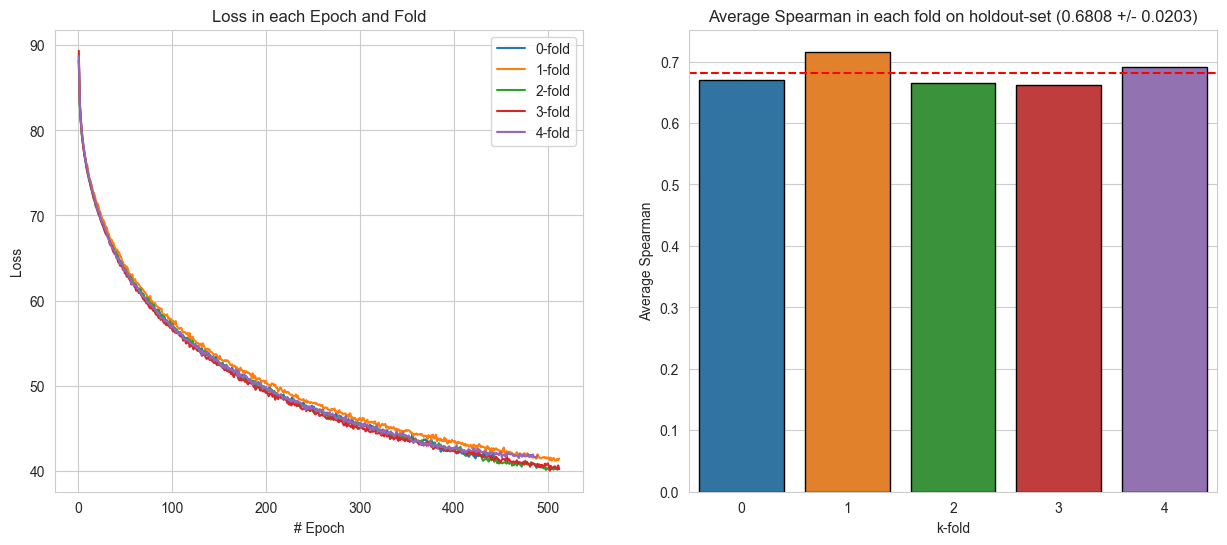

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
for key, item in histories.items():
    loss = item.history["loss"]
    sns.lineplot(x=np.arange(1, len(loss)+1), y=loss, label=key, ax=axes[0])
axes[0].legend()
axes[0].set_title("Loss in each Epoch and Fold")
axes[0].set_xlabel("# Epoch")
axes[0].set_ylabel("Loss")
# Second plot
sns.barplot(x=np.arange(0, len(scores)), y=scores, ax=axes[1], edgecolor="black")
axes[1].set_title(f"Average Spearman in each fold on holdout-set" +
                  f" ({np.mean(scores):.4f} +/- {np.std(scores):.4f})")
axes[1].set_xlabel("k-fold")
axes[1].set_ylabel("Average Spearman")
axes[1].axhline(y=np.mean(scores), linestyle="--", color="red")
plt.show()

In [30]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 40)                1640      
                                                                 
 dense_36 (Dense)            (None, 512)               20992     
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_7 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_38 (Dense)            (None, 512)               524800    
                                                      

In [31]:
pd.DataFrame({"scores": scores}).to_csv(f"results_{str(datetime.datetime.now()).replace('.', '_')}.csv")